In [1]:
import os
import time
from lib.data_parser import DataParser
from lib.data_manager import DataManager
from lib.util import load_file

def process_event_threads(base_path: str, event_name: str, data_manager: DataManager, parser: DataParser, combined_followers_file):
    """Processes all threads for a specific event."""
    
    thread_count = 0
    for thread_id in os.listdir(f"{base_path}/{event_name}"):
        thread_count += 1

        # Process source tweets
        source_tweet_dir = f"{base_path}/{event_name}/{thread_id}/source-tweets"
        for source_tweet_file in os.listdir(source_tweet_dir):
            source_tweet = load_file(f"{source_tweet_dir}/{source_tweet_file}")
            new_tweet = parser.parse_tweet(source_tweet, thread_id, event_name)
            data_manager.add_data(new_tweet)

        # Process reactions
        reaction_dir = f"{base_path}/{event_name}/{thread_id}/reactions"
        for reaction_file in os.listdir(reaction_dir):
            reaction_tweet = load_file(f"{reaction_dir}/{reaction_file}")
            new_tweet = parser.parse_tweet(reaction_tweet, thread_id, event_name)
            data_manager.add_data(new_tweet)

        # Process retweets
        retweets_file_path = f"{base_path}/{event_name}/{thread_id}/retweets.json"
        if os.path.exists(retweets_file_path):
            retweets = load_file(retweets_file_path)
            for retweet in retweets:
                new_tweet = parser.parse_tweet(retweet, thread_id, event_name)
                data_manager.add_data(new_tweet)

        # Combine follower data
        followers_file_path = f"{base_path}/{event_name}/{thread_id}/who-follows-whom.dat"
        if os.path.exists(followers_file_path):
            with open(followers_file_path, 'r') as followers_file:
                for line in followers_file:
                    combined_followers_file.write(line)

    return thread_count

In [2]:
event_names = ["ebola-essien"]

start_time = time.time()
base_path = "pheme-raw/threads/en"
data_manager = DataManager()
parser = DataParser("pheme-raw/annotations/en-scheme-annotations.json")

thread_count = 0
combined_followers_file_path = "data/who-follows-whom.dat"

with open(combined_followers_file_path, 'w') as combined_followers_file:
    for event_name in event_names:
        processed_threads = process_event_threads(base_path, event_name, data_manager, parser, combined_followers_file)
        thread_count += processed_threads

print(f"{thread_count} threads were processed for event(s): {', '.join(event_names)}")
print(f"Data processed in {(time.time() - start_time) / 60:.2f} minutes")

Number of annotations: 4560
2 threads were processed for event(s): ebola-essien
Data processed in 0.00 minutes


In [8]:
# Save tweets data to CSV for further analysis
tweets_df = data_manager.get_tweets_df()
tweets_df.to_csv("data/tweets/tweets_data.csv", index=False)
print("Tweet data has been saved to 'data/tweets/tweets_data.csv'.")

Tweet data has been saved to 'data/tweets/tweets_data.csv'.


In [4]:
# Double check null data!
tweets_df = data_manager.get_tweets_df()
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   thread_id                 216 non-null    int64 
 1   tweet_id                  216 non-null    int64 
 2   user_id                   216 non-null    int64 
 3   event                     216 non-null    object
 4   tweet_class               216 non-null    object
 5   in_reply_to_status_id     216 non-null    int64 
 6   in_reply_to_user_id       216 non-null    int64 
 7   support                   2 non-null      object
 8   responsetype_vs_source    32 non-null     object
 9   responsetype_vs_previous  10 non-null     object
 10  favorite_count            216 non-null    int64 
 11  retweet_count             216 non-null    int64 
 12  created_at                216 non-null    object
 13  place                     2 non-null      object
dtypes: int64(7), object(7)
mem

In [5]:
tweets_df.head()

,thread_id,tweet_id,user_id,event,tweet_class,in_reply_to_status_id,in_reply_to_user_id,support,responsetype_vs_source,responsetype_vs_previous,favorite_count,retweet_count,created_at,place
0,521346721226711040,521346721226711040,579635019,ebola-essien,source,0,0,supporting,None,None,85,575,Sun Oct 12 17:08:39 +0000 2014,None
1,521346721226711040,521349366037356544,463260500,ebola-essien,direct reply,521346721226711040,579635019,None,appeal-for-more-information,None,5,1,Sun Oct 12 17:19:09 +0000 2014,None
2,521346721226711040,521349434719076352,430026970,ebola-essien,direct reply,521346721226711040,579635019,None,comment,None,1,1,Sun Oct 12 17:19:26 +0000 2014,None
3,521346721226711040,521350130851921921,379856833,ebola-essien,direct reply,521346721226711040,579635019,None,comment,None,0,0,Sun Oct 12 17:22:12 +0000 2014,"{'full_name': 'Brasília, Distrito Federal', 'u..."
4,521346721226711040,521350466647891968,458672503,ebola-essien,direct reply,521346721226711040,579635019,None,comment,None,1,0,Sun Oct 12 17:23:32 +0000 2014,None


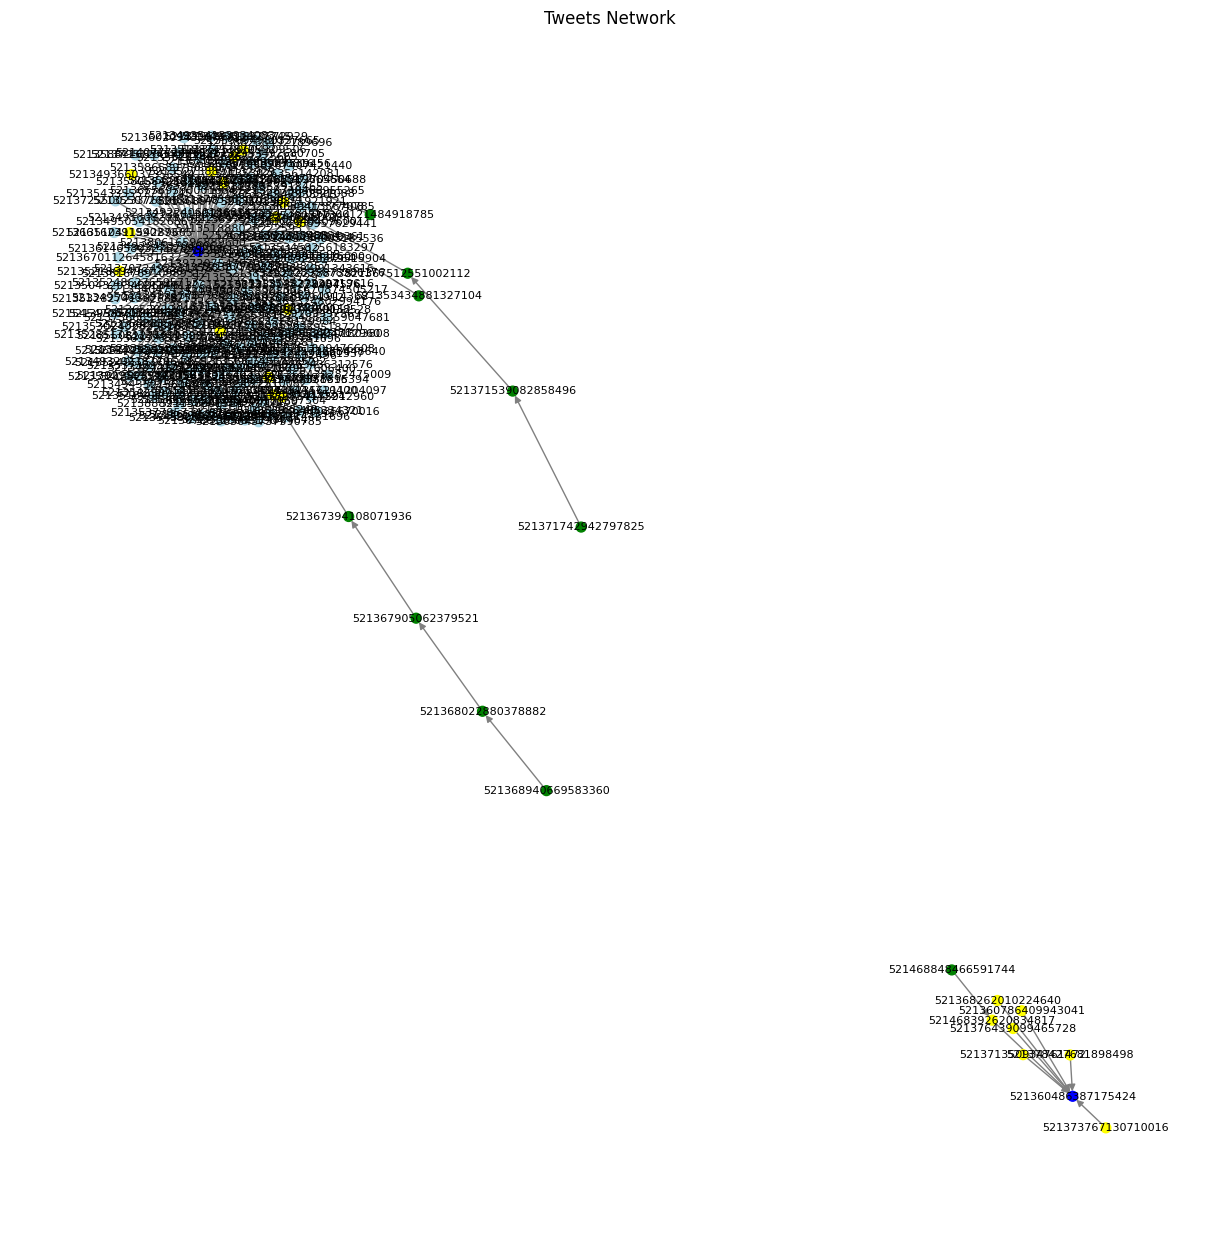

In [6]:
from lib.util import build_tweet_graph, draw_tweet_network

tweet_graph = build_tweet_graph(tweets_df)
draw_tweet_network(tweet_graph)